In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error

def generate_time_series(n_periods=100,
                         frequency='days',
                         trend_slope=0.3,
                         seasonal_period='monthly',
                         seasonal_amplitude=5,
                         noise_level=0.5):
    # Set frequency based on the input (days, months, or weeks)
    if frequency == 'days':
        freq = 'D'
        time_index = pd.date_range(start='2024-01-01', periods=n_periods, freq=freq)
    elif frequency == 'months':
        freq = 'ME'
        time_index = pd.date_range(start='2024-01-01', periods=n_periods, freq=freq)
    elif frequency == 'weeks':
        freq = 'W'
        time_index = pd.date_range(start='2024-01-01', periods=n_periods, freq=freq)
    else:
        raise ValueError("Frequency should be 'days', 'months', or 'weeks'.")

    # 1. Create a linear trend
    trend = np.linspace(0, trend_slope * n_periods, n_periods)

    # 2. Add seasonality based on the chosen period
    if seasonal_period == 'monthly':
        seasonal_frequency = 2 * np.pi / 12
    elif seasonal_period == 'weekly':
        seasonal_frequency = 2 * np.pi / 52
    elif seasonal_period == 'annual':
        seasonal_frequency = 2 * np.pi / 365
    else:
        raise ValueError("Seasonal period should be 'monthly', 'weekly', or 'annual'.")

    seasonal_component = seasonal_amplitude * np.sin(
        np.linspace(0, seasonal_frequency * n_periods, n_periods)
    )

    # 3. Add noise
    noise = np.random.normal(0, noise_level, n_periods)

    # 4. Combine components
    bookings = trend + seasonal_component + noise

    # Data in CSV
    data = {'Time': time_index[:len(bookings)], 'Bookings': bookings}
    df = pd.DataFrame(data)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(df['Time'], df['Bookings'], label='Generated Hotel Bookings')
    plt.title('Generated Hotel Bookings with Trend and Seasonality')
    plt.xlabel('Time')
    plt.ylabel('Bookings')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Save to CSV
    df.to_csv('vger_hotel_bookings.csv', index=False)
    print("Time series data saved to 'vger_hotel_bookings.csv'.")

    return df


def decompose_time_series(df, frequency='D'):
    # Ensure the 'Time' column is in datetime format
    df['Time'] = pd.to_datetime(df['Time'])

    # Set 'Time' as the index
    df.set_index('Time', inplace=True)

    # Perform decomposition (12 for monthly)
    decomposition = seasonal_decompose(
        df['Bookings'],
        model='additive',
        period=365 if frequency == 'days' else 12
    )

    # Plot the decomposed components
    plt.figure(figsize=(12, 8))

    plt.subplot(411)
    plt.plot(decomposition.observed, label='Observed')
    plt.title('Observed')

    plt.subplot(412)
    plt.plot(decomposition.trend, label='Trend', color='orange')
    plt.title('Trend')

    plt.subplot(413)
    plt.plot(decomposition.seasonal, label='Seasonal', color='green')
    plt.title('Seasonal')

    plt.subplot(414)
    plt.plot(decomposition.resid, label='Residuals', color='red')
    plt.title('Residuals')

    plt.tight_layout()
    plt.show()


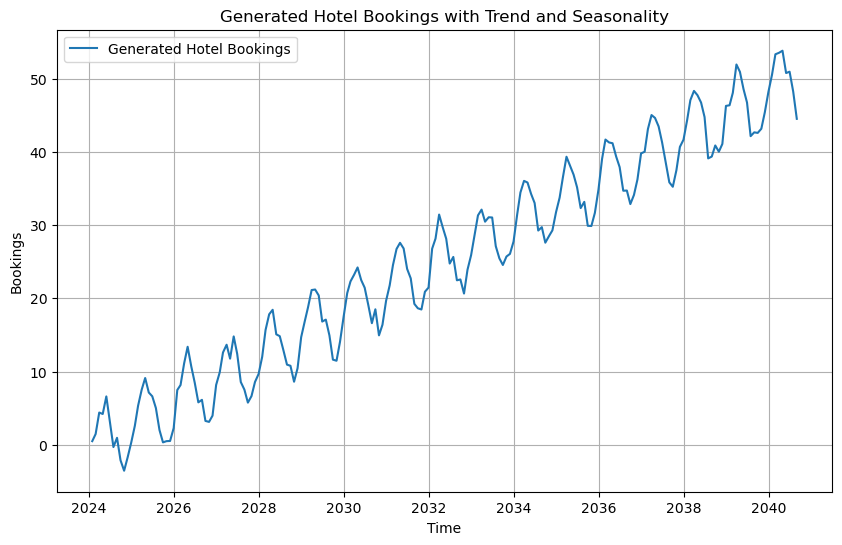

Time series data saved to 'vger_hotel_bookings.csv'.
Clean time series saved to vger_hotel_bookings_clean.csv
        Time  Bookings
0 2024-01-31        14
1 2024-02-29        15
2 2024-03-31        18
3 2024-04-30        18
4 2024-05-31        20
          Time  Bookings
195 2040-04-30        67
196 2040-05-31        64
197 2040-06-30        65
198 2040-07-31        62
199 2040-08-31        58
Min/Max: 10 67


In [2]:
# Generate raw series
df = generate_time_series(
    n_periods=200,         
    frequency="months",
    trend_slope=0.25,
    seasonal_period="monthly",
    seasonal_amplitude=5,
    noise_level=0.9
)

# Change so all values are positive
min_val = df["Bookings"].min()
df["Bookings"] = df["Bookings"] - min_val + 10

# Convert to integers (realistic booking counts)
df["Bookings"] = df["Bookings"].round().astype(int)

# Save clean version
df.to_csv("vger_hotel_bookings_clean.csv", index=False)
print("Clean time series saved to vger_hotel_bookings_clean.csv")
print(df.head())
print(df.tail())
print("Min/Max:", df["Bookings"].min(), df["Bookings"].max())


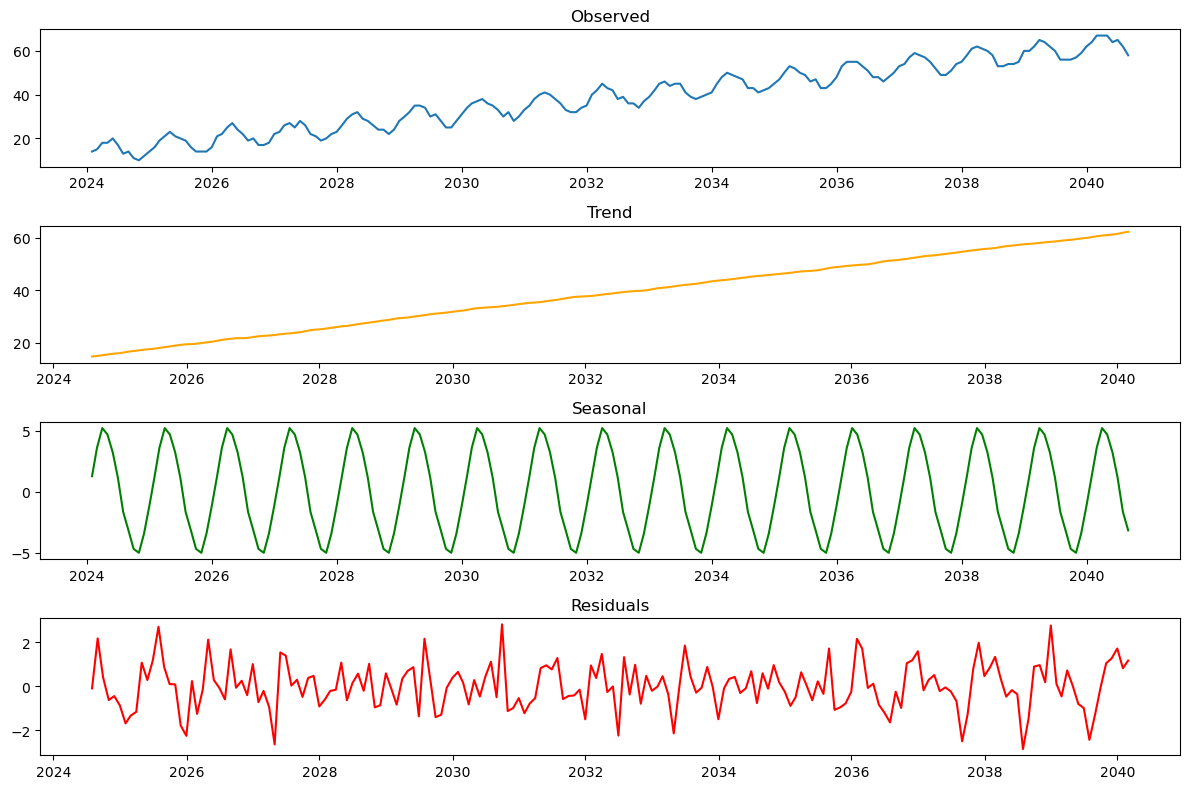

In [3]:
# Reload the cleaned hotel bookings file
df_analysis = pd.read_csv('vger_hotel_bookings_clean.csv')

# Run decomposition (Analysis Step)
decompose_time_series(df_analysis, frequency='M')


Training Data: 188 months
Test Data: 12 months


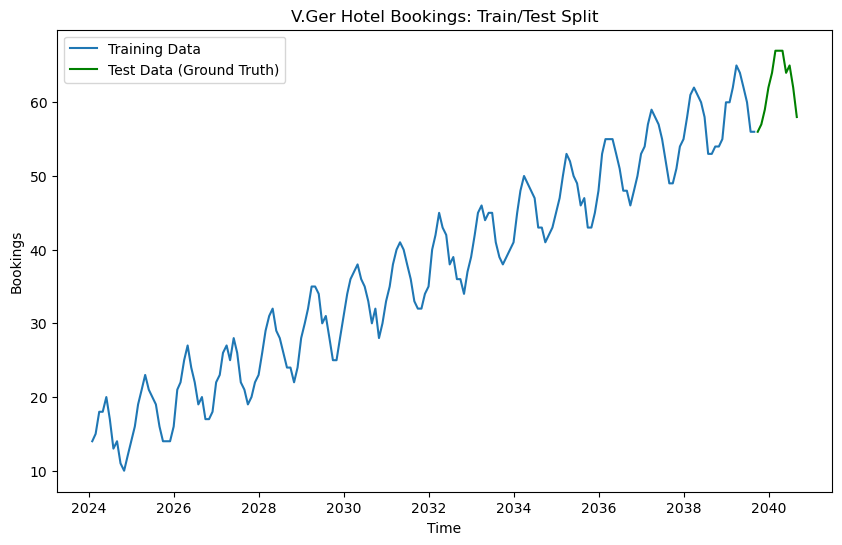

In [4]:
#load data(cleaned version)
data = pd.read_csv('vger_hotel_bookings_clean.csv')
data['Time'] = pd.to_datetime(data['Time'])
data.set_index('Time', inplace=True)


#Train data and test data
train_data = data.iloc[:-12]
test_data = data.iloc[-12:]

#Print
print(f"Training Data: {len(train_data)} months")
print(f"Test Data: {len(test_data)} months")

#Plot
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['Bookings'], label='Training Data')
plt.plot(test_data.index, test_data['Bookings'], label='Test Data (Ground Truth)', color='green')
plt.title('V.Ger Hotel Bookings: Train/Test Split')
plt.xlabel('Time')
plt.ylabel('Bookings')
plt.legend()
plt.show()

ADF Statistic (original): -0.5001242377667282
p-value (original): 0.891992250133987
Critical values: {'1%': np.float64(-3.466398230774071), '5%': np.float64(-2.8773796387256514), '10%': np.float64(-2.575213838610586)}

After first differencing:
ADF Statistic (diff): -8.94756829503733
p-value (diff): 8.902742440930916e-15
Critical values: {'1%': np.float64(-3.466398230774071), '5%': np.float64(-2.8773796387256514), '10%': np.float64(-2.575213838610586)}


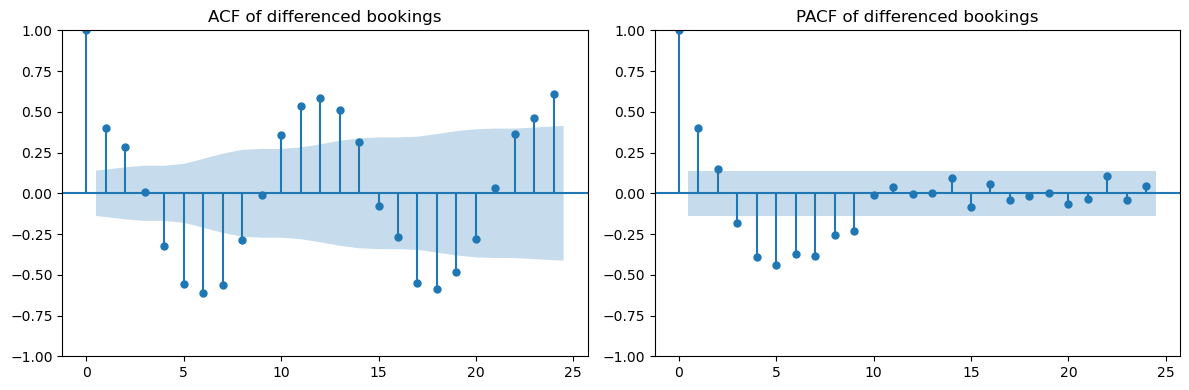

In [5]:
# ADF stationarity test on original series
result = adfuller(data['Bookings'])
print("ADF Statistic (original):", result[0])
print("p-value (original):", result[1])
print("Critical values:", result[4])

# First difference + ADF (again)
data_diff = data['Bookings'].diff().dropna()
result_diff = adfuller(data_diff)
print("\nAfter first differencing:")
print("ADF Statistic (diff):", result_diff[0])
print("p-value (diff):", result_diff[1])
print("Critical values:", result_diff[4])

# ACF and PACF of differenced series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data_diff, lags=24, ax=axes[0])
axes[0].set_title('ACF of differenced bookings')
plot_pacf(data_diff, lags=24, ax=axes[1])
axes[1].set_title('PACF of differenced bookings')
plt.tight_layout()
plt.show()


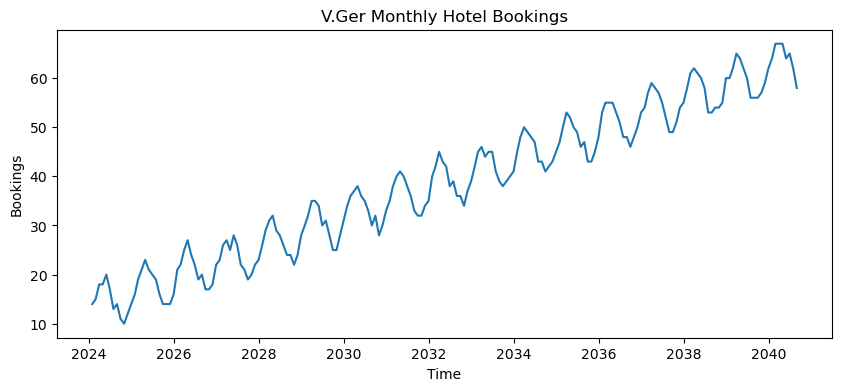

ADF Statistic (original): -0.5001242377667282
p-value (original): 0.891992250133987
Critical values: {'1%': np.float64(-3.466398230774071), '5%': np.float64(-2.8773796387256514), '10%': np.float64(-2.575213838610586)}

After first differencing:
ADF Statistic (diff): -8.94756829503733
p-value (diff): 8.902742440930916e-15
Critical values: {'1%': np.float64(-3.466398230774071), '5%': np.float64(-2.8773796387256514), '10%': np.float64(-2.575213838610586)}


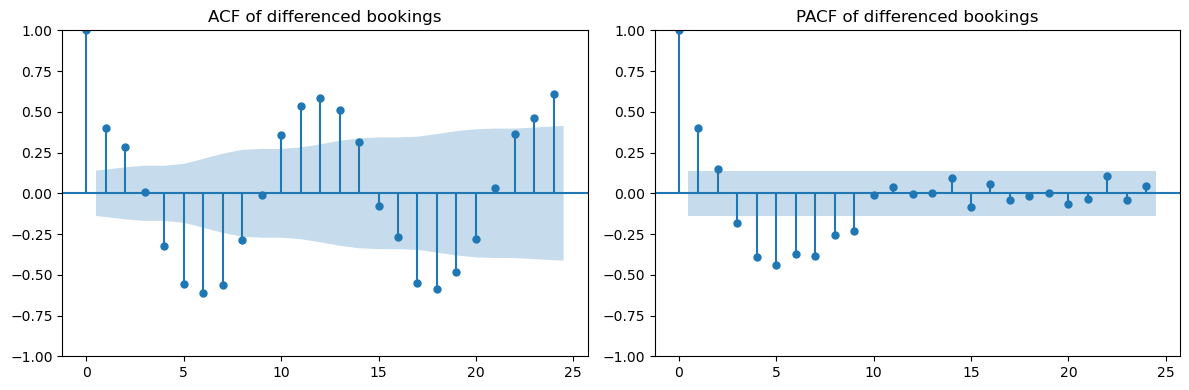

Training observations: 188
Test observations: 12
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=843.014, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=748.554, Time=0.25 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=800.110, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=842.819, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=812.429, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=675.920, Time=0.62 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=798.383, Time=0.13 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=673.469, Time=0.82 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=2.04 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=673.609, Time=0.98 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=700.099, Time=0.87 sec
 ARIMA(2,1,0)(2,0,1)[12] intercept   : AIC=664.120, Time=1.10 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=665.262, Time=0

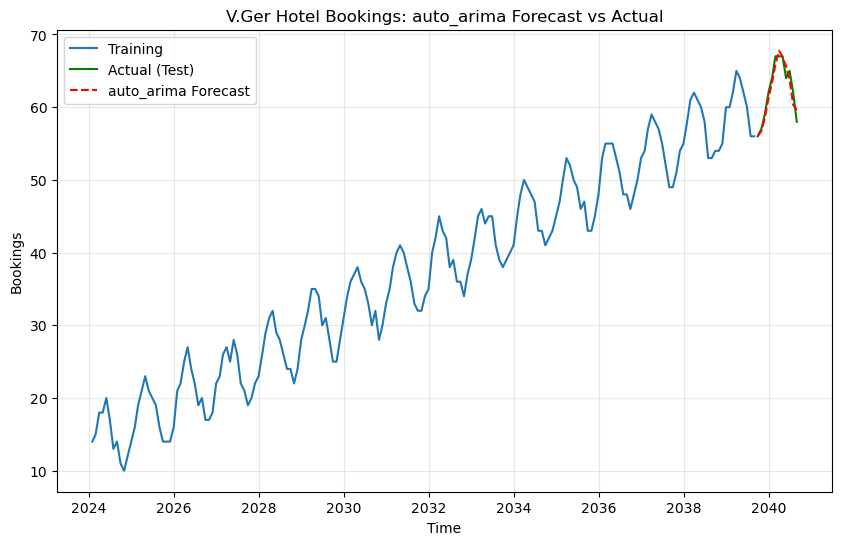

Mean Absolute Error (MAE): 0.86


In [6]:
#Plot
plt.figure(figsize=(10, 4))
plt.plot(data['Bookings'])
plt.title('V.Ger Monthly Hotel Bookings')
plt.xlabel('Time')
plt.ylabel('Bookings')
plt.show()

# ADF test (original series)
result = adfuller(data['Bookings'])
print("ADF Statistic (original):", result[0])
print("p-value (original):", result[1])
print("Critical values:", result[4])

# first iniitla difference + ADF once again
data_diff = data['Bookings'].diff().dropna()
result_diff = adfuller(data_diff)
print("\nAfter first differencing:")
print("ADF Statistic (diff):", result_diff[0])
print("p-value (diff):", result_diff[1])
print("Critical values:", result_diff[4])

# SACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data_diff, lags=24, ax=axes[0])
axes[0].set_title('ACF of differenced bookings')
plot_pacf(data_diff, lags=24, ax=axes[1])
axes[1].set_title('PACF of differenced bookings')
plt.tight_layout()
plt.show()

#Train/test split (last 12 months as test)
train = data.iloc[:-12]
test = data.iloc[-12:]

#print
print(f"Training observations: {len(train)}")
print(f"Test observations: {len(test)}")

# auto_arima model
auto_model = auto_arima(
    train['Bookings'],
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    d=None,
    seasonal=True,
    m=12,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    D=None,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(auto_model.summary())

# forecast next 12 months
n_test = len(test)
forecast = auto_model.predict(n_periods=n_test)

# plot forecast vs actual 
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Bookings'], label='Training')
plt.plot(test.index, test['Bookings'], label='Actual (Test)', color='green')
plt.plot(test.index, forecast, label='auto_arima Forecast', color='red', linestyle='--')
plt.title('V.Ger Hotel Bookings: auto_arima Forecast vs Actual')
plt.xlabel('Time')
plt.ylabel('Bookings')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Final evaluation with MAE 
mae = mean_absolute_error(test['Bookings'], forecast)
print(f"Mean Absolute Error (MAE): {mae:.2f}")
